In [1]:
!gpustat

blade                Mon Jul 12 14:21:46 2021  455.45.01
[0] RTX A6000        | 85'C,  97 % | 44898 / 48685 MB | wangh19(44895M)
[1] RTX A6000        | 83'C,  71 % | 44884 / 48685 MB | wangh19(44881M)
[2] RTX A6000        | 58'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 78'C,  69 % | 44108 / 48685 MB | wangh19(44105M)
[4] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 77'C,  84 % | 44452 / 48685 MB | gkissas(44449M)
[6] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 26'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [30]:
path = 'toy/'

In [31]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [32]:
from helpers import *

In [33]:
key = random.PRNGKey(int(time.time()*100))

In [34]:
def fun_gen(key, freq, N, A = 2):
    def fun(X):
        components = (np.array([A * np.sin(f * np.pi * X) for A, f in zip(A * random.uniform(key, shape = (N,)), freq * random.uniform(random.split(key)[0],shape = (N,)))]))
        return components.sum((0))
    return fun
        

In [35]:
max_freq = 4
N_freq = 4
target_fn = fun_gen(key, max_freq, N_freq)

X_raw = random.uniform(key, shape = (256, 1), minval = -1, maxval = 1)
Y = target_fn(X_raw)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.05
mu_X, sigma_X = X_raw.mean(0), X_raw.std(0)
X = (X_raw - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

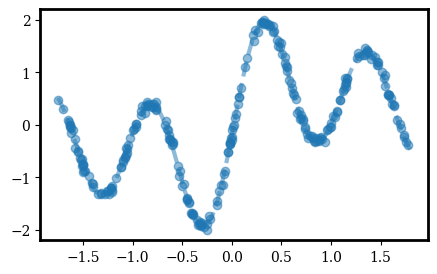

In [36]:
batch = (X, Y)

X_test = np.linspace(-1,1,400).reshape(-1,1)

Y_test = (target_fn(X_test) - mu_Y) / sigma_Y
X_test = (X_test - mu_X) / sigma_X

plt.figure(figsize = (5,3))
plt.plot(X_test, Y_test, linewidth = 3, linestyle = '--', alpha = 0.5, label = 'Target')
plt.scatter(X, Y, alpha = 0.5, label = 'Data')
plt.show()
plt.close()

In [37]:
for lam in [1e-2, 1e-4, 1e-5]:
    layers = [X.shape[1], *[32 for _ in range(4)], 1]
    activation = np.tanh
    fit_model = MLPRegression(layers, activation = activation)
    init_model = initNet(layers[:-1], activation = activation)

    lr = 5e-3
    init_fn, update_fn, get_params = optimizers.adam(lr)
    # init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
#     lam = 1e-3
    @jit
    def step(i, state, X):
        key = random.PRNGKey(i)
        g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
        return update_fn(i, g, state)

    opt_state = init_fn(init_model.scale_params)
    init_nIter = 10000
    pbar = trange(init_nIter)
    scale_stor = []
    bias_stor = []

    for i in pbar:
        opt_state = step(i, opt_state, X)

        if i % 100 == 0:
            params = get_params(opt_state)
            pbar.set_postfix({'lam' : lam,'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), X)})
            scale_stor.append([w for (w, b) in params])
            bias_stor.append([b for (w, b) in params])


    scale_stor = np.array(scale_stor)
    bias_stor = np.array(bias_stor)



    scale_params = params
    fit_model.scaling = lambda params, scale_params: parameter_scaling(params[:-1], scale_params) + [params[-1]]
    fit_model.scaled_net_params = fit_model.scaling(fit_model.net_params, scale_params)

    normal_init_params = vmap(fit_model.net_init)(random.split(key, 16))
    scale_init_params = vmap(fit_model.scaling, in_axes = (0, None))(normal_init_params, scale_params)
    cat_fn = lambda *x: np.concatenate(x)
    #
    # Change to 32 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Set save
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #
    reps = 32
    repeat_fn = lambda x, rep = reps : np.array([x for _ in range(rep)])
    init_params = tree_map(repeat_fn, tree_multimap(cat_fn, normal_init_params, scale_init_params))
    init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-3, decay_steps = 100, decay_rate = 0.99))

    @jit
    def step(i, state, batch):
        g = grad(fit_model.loss)(get_params(state), batch)
        return update_fn(i, g, state)


    vv_step = jit(vmap(vmap(step, in_axes = [None, 0, None]), in_axes = (None, 0, 0)))

    num_data = 256

    nIter = 40000

    max_freqs = np.arange(1, 17) * 4
    N_freq = 4

    loss_stor = []

    test_grid = np.linspace(-1,1,400).reshape(-1,1)
    freq_train_loss = np.zeros((reps, 32))

    for max_freq in max_freqs:

        Xs = []
        Ys = []
        Xs_test = []
        Ys_test = []
        for _ in range(reps):


            key,_ = random.split(key)


            target_fn = fun_gen(key, max_freq, N_freq)

            X_raw = random.uniform(key, shape = (num_data, 1), minval = -1, maxval = 1)
            Y = target_fn(X_raw)
            Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.05
            mu_X, sigma_X = X_raw.mean(0), X_raw.std(0)
            X = (X_raw - mu_X) / sigma_X
            mu_Y, sigma_Y = Y.mean(0), Y.std(0)
            Y = (Y - mu_Y) / sigma_Y

            Y_test = target_fn(test_grid)
            Y_test = (Y_test - mu_Y) / sigma_Y

            X_test = (test_grid - mu_X) / sigma_X

            Xs.append(X)
            Ys.append(Y)

            Xs_test.append(X_test)
            Ys_test.append(Y_test)

        Xs = np.array(Xs)
        Ys = np.array(Ys)

        Xs_test = np.array(Xs_test)
        Ys_test = np.array(Ys_test)





        opt_state = vmap(vmap(init_fn))(init_params)
        pbar = trange(nIter)
        pbar.set_postfix({'Max Freq.': max_freq, 'Previous Scaled Train L2': freq_train_loss[:,16:].mean(), 'Previous Normal Train L2': freq_train_loss[:,:16].mean()})
        for i in pbar:
            opt_state = vv_step(i, opt_state, (Xs, Ys))

        opt_params = vmap(vmap(get_params))(opt_state)

        freq_train_loss = vmap(vmap(fit_model.l2_error, in_axes = [0, None]), in_axes = (0, 0))(opt_params, (Xs, Ys))
        freq_test_loss = vmap(vmap(fit_model.l2_error, in_axes = [0, None]), in_axes = (0, 0))(opt_params, (Xs_test, Ys_test))

        loss_stor.append((freq_train_loss, freq_test_loss))


    loss_stor = np.array(loss_stor)
    np.save(path+f'toy_loss_{num_data}_{lam}', loss_stor)
    np.save(path+f'max_freq_{num_data}_{lam}', max_freqs)
        

100%|██████████| 40000/40000 [02:07<00:00, 312.51it/s, Max Freq.=64, Previous Scaled Train L2=0.26677194, Previous Normal Train L2=0.42524764]


In [38]:
normal_loss = loss_stor[:,:,:,:16]
scaled_loss = loss_stor[:,:,:,16:]

In [39]:
normal_loss = normal_loss.reshape(normal_loss.shape[:2] + (-1,))
scaled_loss = scaled_loss.reshape(scaled_loss.shape[:2] + (-1,))

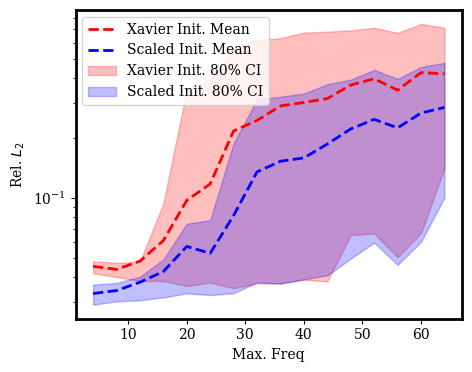

In [40]:
plt.figure(figsize = (5,4))
plt.plot(max_freqs, normal_loss[:,0].mean(1), color = 'r', linestyle = '--', label = 'Xavier Init. Mean')
plt.plot(max_freqs, scaled_loss[:,0].mean(1), color = 'b', linestyle = '--', label = 'Scaled Init. Mean')

plt.fill_between(max_freqs, *np.quantile(normal_loss[:,0], np.array([0.1, 0.9]), 1), color = 'r', alpha = 0.25, label = 'Xavier Init. 80% CI')
plt.fill_between(max_freqs, *np.quantile(scaled_loss[:,0], np.array([0.1, 0.9]), 1), color = 'b', alpha = 0.25, label = 'Scaled Init. 80% CI')
plt.yscale('log')
plt.legend()
plt.xlabel('Max. Freq')
plt.ylabel(r'Rel. $L_2$')
plt.tight_layout()
# plt.savefig(path + f'training_l2_{num_data}.pdf', dpi = 200)
plt.show()
plt.close()

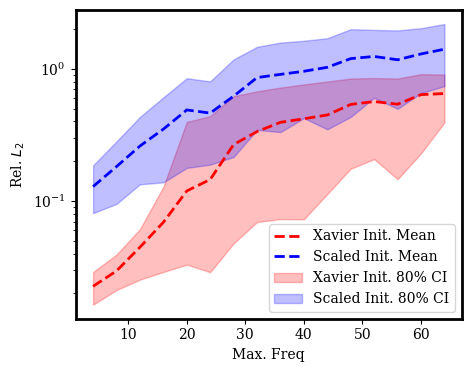

In [41]:
plt.figure(figsize = (5,4))
plt.plot(max_freqs, normal_loss[:,1].mean(1), color = 'r', linestyle = '--', label = 'Xavier Init. Mean')
plt.plot(max_freqs, scaled_loss[:,1].mean(1), color = 'b', linestyle = '--', label = 'Scaled Init. Mean')

plt.fill_between(max_freqs, *np.quantile(normal_loss[:,1], np.array([0.1, 0.9]), 1), color = 'r', alpha = 0.25, label = 'Xavier Init. 80% CI')
plt.fill_between(max_freqs, *np.quantile(scaled_loss[:,1], np.array([0.1, 0.9]), 1), color = 'b', alpha = 0.25, label = 'Scaled Init. 80% CI')
plt.yscale('log')
plt.legend()
plt.xlabel('Max. Freq')
plt.ylabel(r'Rel. $L_2$')
plt.tight_layout()
# plt.savefig(path + f'test_l2_{num_data}.pdf', dpi = 200)
plt.show()
plt.close()